In [3]:
import numpy as np
import math
import matplotlib
%matplotlib inline
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import skimage.transform as sktr
import cv2
import skimage as sk
import skimage.io as skio
from scipy import interpolate
import numpy as np
import skimage.io as io

import matplotlib
%matplotlib inline

import utils, morph, my_types
from pathlib import Path
data = Path("input")
data.mkdir(parents=True, exist_ok=True)

### Mark Correspondences

In [4]:
# Align images
def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

In [5]:
def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

In [6]:
def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

In [7]:
def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

In [8]:
def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale, multichannel = True)
    else:
        im2 = sktr.rescale(im2, 1./dscale, multichannel = True)
    return im1, im2

In [9]:
def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

In [10]:
def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

In [11]:
def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [12]:
# Correspondence
def define_points(img):
    print('Please select 36 points in image.')
    plt.imshow(img)
    pts = plt.ginput(36, timeout=500)
    plt.close()
    return pts

In [19]:
# read in the image
im = plt.imread('input/me.jpg')
target_im = plt.imread('input/iu.jpg')

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
target_im = sk.img_as_float(target_im)

In [22]:
# im_aligned, target_aligned = align_images(im, target_im)
im_aligned, target_aligned = im, target_im

In [27]:
# Define corresponding points
# points_im = define_points(im_aligned)
# points_target = define_points(target_aligned)
points_im = utils.load_points("input/me.pkl")
points_target = utils.load_points("input/iu.pkl")

### Computing the Mid-point Face

In [28]:
# Computing the average shape
def get_avg_shape(points_i, points_t, t):
    avg_shape = (1-t) * points_i + t * points_t
    return avg_shape

In [29]:
from scipy.spatial import Delaunay
import matplotlib
%matplotlib inline
from skimage.draw import polygon
from scipy import interpolate

In [30]:
# points_im = np.array([(213.32826490066236, 269.3977483443707), (327.24614569536425, 225.58317880794687), (434.1536953642385, 267.6451655629138), (195.80243708609282, 378.0578807947019), (222.09117880794713, 358.7794701986754), (276.42124503311265, 367.5423841059602), (367.55554966887416, 364.03721854304627), (423.6381986754968, 343.0062251655628), (446.4217748344372, 365.7898013245032), (208.0705165562914, 414.86211920529786), (241.36958940397358, 404.3466225165562), (272.9160794701987, 420.1198675496687), (367.55554966887416, 414.86211920529786), (400.85462251655645, 397.3362913907283), (428.89594701986766, 404.3466225165562), (325.49356291390745, 495.48092715231775), (285.1841589403974, 518.2645033112582), (330.7513112582783, 527.027417218543), (364.05038410596035, 509.5015894039734), (260.648, 553.3161589403973), (325.49356291390745, 544.5532450331125), (325.49356291390745, 560.326490066225), (327.24614569536425, 572.5945695364237), (388.58654304635775, 548.0584105960263), (178.27660927152328, 458.6766887417217), (202.81276821192057, 560.326490066225), (334.2564768211921, 646.2030463576158), (456.9372715231789, 539.2954966887417), (476.21568211920544, 421.8724503311257), (243.1221721854305, 674.2443708609271), (346.5245562913908, 798.6777483443707), (442.91660927152316, 681.2547019867549), (4.7709139072848075, 59.08781456953625), (640.9584635761589, 45.06715231788064), (-0.48683443708603136, 693.5227814569535), (640.9584635761589, 712.80119205298)])
# points_target = np.array([(200.96849139290362, 265.55300188127296), (317.8792885960049, 238.5735871420958), (427.59557520199235, 258.3584912841591), (181.18358725084022, 380.6651714350959), (208.1630019900175, 353.6857566959187), (276.51085266259986, 366.2761502408681), (352.0532139322961, 362.6788949423111), (440.18596874694174, 353.6857566959187), (461.7695005382835, 368.0747778901465), (208.1630019900175, 416.63772442066556), (238.73967202775168, 404.04733087571617), (278.30948031187836, 422.03360736850107), (361.0463521786886, 422.03360736850107), (400.6161604628152, 398.6514479278808), (429.39420285127096, 409.4432138235517), (319.6779162452834, 492.18008569036186), (280.10810796115686, 513.7636174817037), (323.27517154384043, 524.5553833773745), (368.2408627758025, 519.1595004295391), (267.51771441620747, 576.7155852064506), (323.27517154384043, 560.5279363629443), (321.4765438945619, 574.916957557172), (325.07379919311893, 601.8963722963493), (386.2271392685874, 578.514212855729), (152.40554486238455, 443.61713915984285), (186.57947019867572, 562.3265640122227), (335.8655650887898, 677.4387335660456), (483.35303232962553, 540.7430322208809), (501.3393088224103, 423.83223501777945), (197.3712360943466, 722.4044247980077), (312.48340564816954, 815.9330625604888), (456.37361759044813, 726.0016800965647), (3.119449972270445, 4.751992735892941), (638.035010167575, 4.751992735892941), (6.716705270827333, 740.3907012907925), (636.2363825182964, 814.1344349112103)])

In [31]:
avg_points = get_avg_shape(points_im, points_target, 0.5)

In [32]:
tri = Delaunay(avg_points)

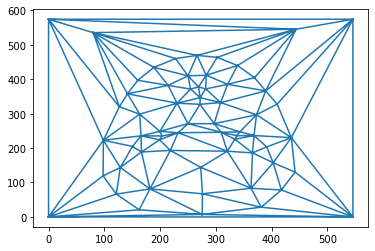

In [33]:
plt.triplot(avg_points[:,0], avg_points[:,1], tri.simplices)
plt.show()

In [34]:
# Affine transformation
def compute_affine(tri1_pts, tri2_pts):
    source = np.vstack((tri1_pts.T, [1, 1, 1]))
    target = np.vstack((tri2_pts.T, [1, 1, 1]))
    
    A = np.dot(target, np.linalg.inv(source))
    inverse_A = np.linalg.inv(A)
    return inverse_A

In [43]:
# Warp images to shape
def warp_image_to(im, im_points, avg_points, del_tri):  
    x, y, _ = im.shape
    # Points of triangles
    im_t_points = im_points[del_tri].copy()
    avg_t_points = avg_points[del_tri].copy()
    
    # Affine transformations 
    affine_mats = []
    
    # Affine transformations for triangles
    for i in range(len(del_tri)):
        affine_mats.append(compute_affine(im_t_points[i], avg_t_points[i]))
    
    # Create warped image
    new_im = np.zeros(im.shape)
    
    # Interpolation functions
    f_red = interpolate.RectBivariateSpline(range(im.shape[0]), range(im.shape[1]), im[:,:, 0])
    f_green = interpolate.RectBivariateSpline(range(im.shape[0]), range(im.shape[1]), im[:,:, 1])
    f_blue = interpolate.RectBivariateSpline(range(im.shape[0]), range(im.shape[1]), im[:,:, 2])
    
    for i in range(len(affine_mats)): 
        # Mask
        rr, cc = polygon(avg_t_points[i].T[0], avg_t_points[i].T[1], shape=(y, x))
        # Transform points to the source image domain
        transformed = np.around(affine_mats[i] @ np.vstack((rr, cc, np.ones(len(rr))))).astype(int)
        # Interpolate
        new_im[cc, rr, 0] = f_red.ev(transformed[1], transformed[0])
        new_im[cc, rr, 1] = f_green.ev(transformed[1], transformed[0])
        new_im[cc, rr, 2] = f_blue.ev(transformed[1], transformed[0])
        
    return new_im

In [36]:
# Find mid-way shape
def find_mid_shape(im1, im2, pts_im, pts_target, avg_pts, del_tri):
    warped_im1 = warp_image_to(im1, pts_im, avg_pts, del_tri)
    warped_im2 = warp_image_to(im2, pts_target, avg_pts, del_tri)
    
    # Cross-dissolve (average)
    mid_photo = 0.5 * (warped_im1) + 0.5 * (warped_im2)
    return warped_im1, warped_im2, mid_photo

In [38]:
# imaname = 'aligned_im.png'
imaname = "input/me.jpg"
im_a = skio.imread(imaname)
im_a = sk.img_as_float(im_a)

# imbname = 'aligned_target.png'
imbname = "input/iu.jpg"
im_b = skio.imread(imbname)
im_b = sk.img_as_float(im_b)

In [39]:
tri_indices = tri.simplices.copy()

In [40]:
points_a = points_im.copy()
points_b = points_target.copy()

im_a = im_a.copy()
im_b = im_b.copy()

In [41]:
a, b, mid = find_mid_shape(im_a, im_b, points_a, points_b, avg_points, tri_indices)

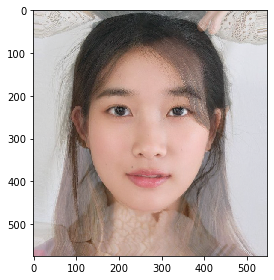

In [42]:
skio.imshow(mid)

In [65]:
# Save midpoint face
fname = './midpoint_me_psj.png'
skio.imsave(fname, mid)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Morph Sequence

In [66]:
def find_mid_shape_dissolve(im1, im2, pts_im, pts_target, avg_pts, del_tri, dis_frac):
    warped_im1 = warp_image_to(im1, pts_im, avg_pts, del_tri)
    warped_im2 = warp_image_to(im2, pts_target, avg_pts, del_tri)
    
    mid_photo = (1 - dis_frac) * (warped_im1) + (dis_frac) * (warped_im2)
    return warped_im1, warped_im2, mid_photo

In [67]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    avg_points = get_avg_shape(im1_pts, im2_pts, warp_frac)   
    w_im1, w_im2, mid_morph = find_mid_shape_dissolve(im1, im2, im1_pts, im2_pts, avg_points, tri, dissolve_frac)
    return mid_morph

In [69]:
# Produced morphed images at each time step
for i in range(46):
    w_frac = i * (1/45)
    d_frac = i * (1/45)
    morphed_im =  morph(im_a, im_b, points_a, points_b, tri_indices, w_frac, d_frac)
    fname = './produced_gif/me_psj' + str(i) + '.png'
    skio.imsave(fname, morphed_im)

Lossy conversion from float64 to uint8. Range [-1.3183898417423734e-16, 0.996078431372549]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conv

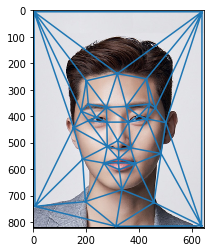

In [76]:
# Save triangulations
img = plt.imread("aligned_target.png")
fig, ax = plt.subplots()
ax.triplot(points_b[:,0], points_b[:,1], tri.simplices)
ax.imshow(img)
fig.savefig("triangulation_psj.png")

### Mean Face of Population

In [70]:
import glob

In [118]:
# Store points 
points = []

# Iterate though each .asf file
asf_files = sorted(glob.glob('dane_imgs/*.asf'))
for asf in asf_files:
    file = open(asf, 'r')
    points_file = [(0, 0), (639, 479), (639, 0), (0, 479)]
    for i, line in enumerate(file):
        if i >= 16 and i <= 73:
            values = line.split()
            x = float(values[2])
            y = float(values[3])
            points_file.append((x*640, y*480))
    points.append(points_file)

In [119]:
# Convert lists to np.arrays
points = np.array(points)

In [120]:
# Average points through out all images
total_n, h, w = points.shape
avg_points = np.zeros((h, w))

for p in points:
    avg_points = avg_points + p

avg_points = avg_points/total_n

In [121]:
# Get triangular indices
tri = Delaunay(avg_points)
tri_indices = tri.simplices.copy()

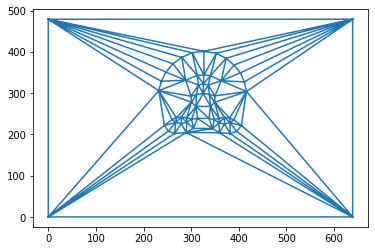

In [122]:
plt.triplot(avg_points[:,0], avg_points[:,1], tri.simplices)
plt.show()

In [123]:
# Iterate through all the images
jpg_files = sorted(glob.glob('dane_imgs/*.jpg'))

all_jpgs = np.zeros((len(points), 480, 640, 3))

for i in range(len(jpg_files)):
    jpg_name = jpg_files[i]
    dane_im = skio.imread(jpg_name)
    dane_im = sk.img_as_float(dane_im)
    all_jpgs[i] = warp_image_to(dane_im, points[i], avg_points, tri_indices)

In [305]:
# Save some warped faces
for i in range(0, len(jpg_files), 10):
    fname = './warped_dane' + str(i+1) +'.png'
    skio.imsave(fname, all_jpgs[i])

Lossy conversion from float64 to uint8. Range [-4.0549161250957866e-17, 0.9019607843137255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-3.252606517456513e-17, 0.9254901960784312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-3.3393426912553537e-17, 0.8980392156862745]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2.981555974335137e-17, 0.9450980392156859]. Convert image to uint8 prior to saving to suppress this warning.


In [124]:
# Average images by color
average_dane = np.zeros(all_jpgs[0].shape)

for pic in all_jpgs:
    average_dane = average_dane + pic

average_dane = average_dane/len(jpg_files)

In [126]:
# Save mean face
fname = './mean_dane.png'
skio.imsave(fname, average_dane)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


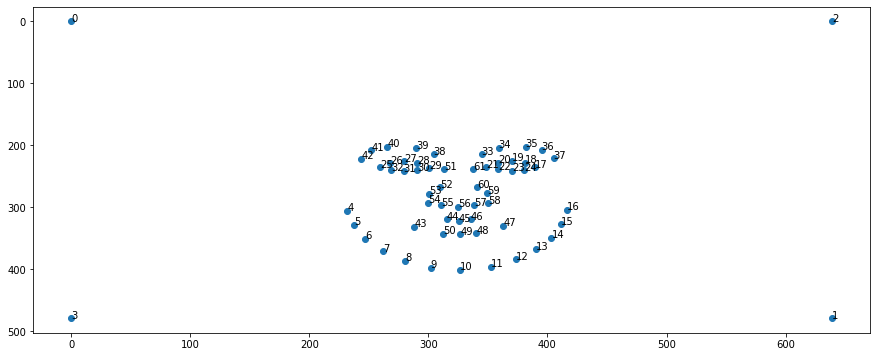

In [147]:
# Annotate image with points
plt.figure(figsize=(15,6))
plt.scatter(avg_points[:, 0], avg_points[:, 1])
for i in range(len(avg_points)):
    plt.annotate(str(i), (avg_points[i][0], avg_points[i][1]))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [148]:
# Correspondence
matplotlib.use('TkAgg')
def define_points_dane(img):
    print('Please select 62 points in image.')
    plt.imshow(img)
    pts = plt.ginput(62, timeout=1000)
    plt.close()
    return pts

In [149]:
dane_me = 'data/me.jpg'
dane_me_im = skio.imread(dane_me)
dane_me_im = sk.img_as_float(dane_me_im)

In [158]:
# Align myself to average dane
dane_me_aligned, average_dane_aligned = align_images(dane_me_im, average_dane)

Please select 2 points in each image for alignment.


In [182]:
points_dane_me = define_points_dane(dane_me_aligned)

Please select 62 points in image.


In [163]:
points_avg_dane = define_points_dane(average_dane_aligned)

Please select 62 points in image.


In [183]:
# Warp myself to Average Dane shape
dane_me_points = np.array(points_dane_me).copy()
dane_avg_points = np.array(points_avg_dane).copy()

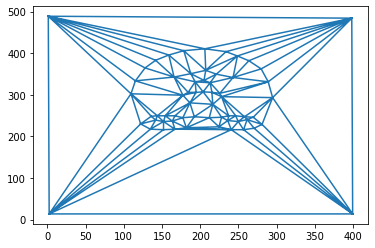

In [184]:
tri = Delaunay(dane_avg_points)
tri_dane_indices = tri.simplices.copy()
plt.triplot(dane_avg_points[:,0], dane_avg_points[:,1], tri.simplices)

In [189]:
me_as_dane = warp_image_to(dane_me_aligned, dane_me_points, dane_avg_points, tri_dane_indices)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


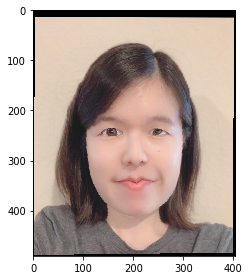

In [193]:
skio.imshow(me_as_dane)
fname = './me_as_dane.png'
skio.imsave(fname, me_as_dane)

In [191]:
dane_as_me = warp_image_to(average_dane_aligned,dane_avg_points, dane_me_points, tri_dane_indices)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


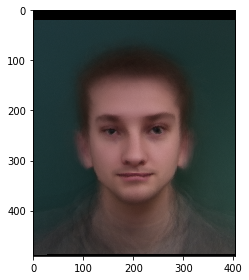

In [194]:
skio.imshow(dane_as_me)
fname = './dane_as_me.png'
skio.imsave(fname, dane_as_me)

In [219]:
# Extrapolate unique features from general population mean
my_diff = dane_me_points - dane_avg_points
h, w, c = dane_me_aligned.shape
caricatures = np.zeros((10, h, w, c))

# Adding more of the difference to my face
fracs = np.arange(0, 2, 0.2)
for i in range(10):
    caric_points = dane_me_points + (fracs[i] * my_diff)
    caricatures[i] = warp_image_to(dane_me_aligned,dane_me_points, caric_points, tri_dane_indices)

In [225]:
# Save caricatures
for i in range(len(caricatures)):
    fname = './caric' + str(i) + '.png'
    skio.imsave(fname, caricatures[i])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [228]:
# Subtract differences from  my face
carics_me = np.zeros((10, h, w, c))
fracs = np.arange(-2, 0, 0.2)
for i in range(10):
    caric_points = dane_me_points + (fracs[i] * my_diff)
    carics_me[i] = warp_image_to(dane_me_aligned, dane_me_points, caric_points, tri_dane_indices)

In [234]:
# Save caricatures opposite dir
for i in range(len(carics_me)):
    fname = './caric_opp' + str(i) + '.png'
    skio.imsave(fname, carics_me[i])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

### Bells and Whistles

In [236]:
# # read in the image
me_im = plt.imread('data/vanessa.jpg')
jason_im = plt.imread('data/jason.jpg')

# convert to double (might want to do this later on to save memory)    
me_im = sk.img_as_float(me_im)
jason_im = sk.img_as_float(jason_im)

In [238]:
points_me = define_points(me_im)
points_jason = define_points(jason_im)

Please select 36 points in image.
Please select 36 points in image.


In [240]:
points_me = np.array(points_me)
points_jason = np.array(points_jason)
avg_points = get_avg_shape(points_me, points_jason, 0.5)

In [243]:
tri = Delaunay(avg_points)
tri_indices = tri.simplices.copy()

In [250]:
# Produced morphed images at each time step
for i in range(51):
    w_frac = i * (1/50)
    d_frac = i * (1/50)
    morphed_im =  morph(me_im, jason_im, points_me, points_jason, tri_indices, w_frac, d_frac)
    fname = './produced_class_morph/me_jason' + str(i) + '.png'
    skio.imsave(fname, morphed_im)

/Users/vanessalin/.conda/envs/p36workshop/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [296]:
# Place points on each image for CLOY actors
son_im = plt.imread('data/sonyejin.jpg')
hyun_im = plt.imread('data/hyunbin.jpg')
seung_im = plt.imread('data/seungjun.jpg')
seo_im = plt.imread('data/seodan.jpg')
duck1_im = plt.imread('data/kwangbum.jpg')
duck2_im = plt.imread('data/subin.jpg')
duck3_im = plt.imread('data/pyochisu.jpg')
duck4_im = plt.imread('data/eundong.jpg')

# convert to double (might want to do this later on to save memory)    
son_im = sk.img_as_float(son_im)
hyun_im = sk.img_as_float(hyun_im)
seung_im = sk.img_as_float(seung_im)
seo_im = sk.img_as_float(seo_im)
duck1_im = sk.img_as_float(duck1_im)
duck2_im = sk.img_as_float(duck2_im)
duck3_im = sk.img_as_float(duck3_im)
duck4_im = sk.img_as_float(duck4_im)

In [254]:
points_son = define_points(son_im)
points_hyun = define_points(hyun_im)

Please select 36 points in image.
Please select 36 points in image.


In [255]:
points_son = np.array(points_son)
points_hyun = np.array(points_hyun)
avg_sh_points = get_avg_shape(points_son, points_hyun, 0.5)

In [258]:
points_seung = define_points(seung_im)

Please select 36 points in image.


In [261]:
points_seung = np.array(points_seung)
avg_hyun_se_points = get_avg_shape(points_hyun, points_seung, 0.5)

In [264]:
points_seo = define_points(seo_im)

Please select 36 points in image.


In [265]:
points_seo = np.array(points_seo)
avg_ss_points = get_avg_shape(points_seung, points_seo, 0.5)

In [273]:
points_duck1 = define_points(duck1_im)

Please select 36 points in image.


In [274]:
points_duck1 = np.array(points_duck1)
avg_sduck1_points = get_avg_shape(points_seo, points_duck1, 0.5)

In [279]:
points_duck2 = define_points(duck2_im)

Please select 36 points in image.


In [280]:
points_duck2 = np.array(points_duck2)
avg_dd_points = get_avg_shape(points_duck1, points_duck2, 0.5)

In [297]:
points_duck3 = define_points(duck3_im)

Please select 36 points in image.


In [298]:
points_duck3 = np.array(points_duck3)
avg_dd_points = get_avg_shape(points_duck2, points_duck3, 0.5)

In [301]:
points_duck4 = define_points(duck4_im)

Please select 36 points in image.


In [302]:
points_duck4 = np.array(points_duck4)
avg_dd_points = get_avg_shape(points_duck3, points_duck4, 0.5)

In [303]:
tri = Delaunay(avg_dd_points)
tri_indices = tri.simplices.copy()

In [277]:
def normalize_im(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm

In [304]:
# Produced morphed images at each time step
for i in range(51):
    w_frac = i * (1/50)
    d_frac = i * (1/50)
    morphed_im =  morph(duck3_im, duck4_im, points_duck3, points_duck4, tri_indices, w_frac, d_frac)
    fname = './cloy/duck3_duck' + str(i) + '.png'
    skio.imsave(fname, normalize_im(morphed_im))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0